# Trading Platform Customer Attrition Risk Prediction using SparkML

There are many users of online trading platforms and these companies would like to run analytics on and predict churn based on user activity on the platform. Since competition is rife, keeping customers happy so they do not move their investments elsewhere is key to maintaining profitability.

In this notebook, we will leverage Data Science Experience Local to do the following:

1. Ingest merged customer demographics and trading activity data
2. Visualize merged dataset and get better understanding of data to build hypotheses for prediction
3. Leverage SparkML library to build classification model that predicts whether customer has propensity to churn
4. Expose SparkML classification model as RESTful API endpoint for the end-to-end customer churn risk prediction and risk remediation application

<img src="https://github.com/elenalowery/DSX_Local_Workshop/blob/master/img/CC_Intro.JPG?raw=true" width="800" height="500" align="middle"/>

<a id="top"></a>
## Table of Contents

1. [Load libraries](#load_libraries)
2. [Load and visualize merged customer demographics and trading activity data](#load_data)
3. [Prepare data for building SparkML classification model](#prepare_data)
4. [Train classification model and test model performance](#build_model)
5. [Save model to ML repository and expose it as REST API endpoint](#save_model)
6. [Summary](#summary)

### Quick set of instructions to work through the notebook

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. The notebook has 2 types of cells - markdown (text) such as this and code such as the one below. 
2. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
3. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
4. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

<a id="load_libraries"></a>
## 1. Load libraries
[Top](#top)

Running the following cell will load all libraries needed to load, visualize, prepare the data and build ML models for our use case

In [1]:
import os
from pyspark.sql import SQLContext
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import brunel
from dsx_ml.ml import save
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import dsx_core_utils, requests, os, io
from pyspark.sql import SparkSession
% matplotlib inline

<a id="load_data"></a>
## 2. Load and visualize merged customer and trading activity data
[Top](#top)

Data can be easily loaded within Data Science Experience Local using point-and-click functionality. The following image illustrates how to laod the merged dataset assuming it is called "customer.csv". File can be located by its name and inserted into the notebook as a Spark dataframe aa shown below

<img src="https://raw.githubusercontent.com/Rui425/ICP4D-/master/pics/InsertRemoteData.png" width="500">

Interface comes up with a generic name and it is good practice to rename the dataframe to match use case context

In [29]:
# Add asset from remote connection
df_churn = None
dataSet = dsx_core_utils.get_remote_data_set_info('CustomerMerged')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
sparkSession = SparkSession(sc).builder.getOrCreate()
# Load JDBC data to Spark dataframe
dbTableOrQuery = (dataSet['schema'] + '.' if(len(dataSet['schema'].strip()) != 0) else '') + dataSet['table']
df_churn = sparkSession.read.format("jdbc").option("url", dataSource['URL']).option("dbtable",dbTableOrQuery).option("user",dataSource['user']).option("password",dataSource['password']).load()
df_churn.show(5)


+---+---------+------+------+--------+---------+---------+---+----------------------+----------------+------------------------+-------------------------+------------------------+------------------+------------------+--------------------+
| ID|CHURNRISK|GENDER|STATUS|CHILDREN|ESTINCOME|HOMEOWNER|AGE|TOTALDOLLARVALUETRADED|TOTALUNITSTRADED|LARGESTSINGLETRANSACTION|SMALLESTSINGLETRANSACTION|PERCENTCHANGECALCULATION|DAYSSINCELASTLOGIN|DAYSSINCELASTTRADE|NETREALIZEDGAINS_YTD|
+---+---------+------+------+--------+---------+---------+---+----------------------+----------------+------------------------+-------------------------+------------------------+------------------+------------------+--------------------+
| 12|   Medium|     F|     S|       0| 78851.30|        N| 48|                370.04|              28|                 92.5100|                  9.25100|                    4.20|                 5|                13|              0.0000|
| 13|     High|     F|     S|       1| 17540.70|

Data Visualization is key step in data mining process that helps better understand data before it can be prepared for building ML models

We use Brunel library that comes preloaded within DSX local environment to visualize the merged customer data. 

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here: http://brunel.mybluemix.net/gallery_app/renderer

In [3]:
df_churn_pd = df_churn.toPandas()

In [4]:
%brunel data('df_churn_pd') stack polar bar x(CHURNRISK) y(#count) color(CHURNRISK) bar tooltip(#all)

<IPython.core.display.Javascript object>

In [5]:
%brunel data('df_churn_pd') bar x(STATUS) y(#count) color(STATUS) tooltip(#all) | stack bar x(STATUS) y(#count) color(CHURNRISK: pink-orange-yellow) bin(STATUS) sort(STATUS) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

In [6]:
%brunel data('df_churn_pd') bar x(TOTALUNITSTRADED) y(#count) color(CHURNRISK: pink-gray-orange) sort(STATUS) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

In [7]:
%brunel data('df_churn_pd') bar x(DAYSSINCELASTTRADE) y(#count) color(CHURNRISK: pink-gray-orange) sort(STATUS) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

<a id="prepare_data"></a>
## 3. Data preparation
[Top](#top)

Data preparation is a very important step in machine learning model building. This is because the model can perform well only when the data it is trained on is good and well prepared. Hence, this step consumes bulk of data scientist's time spent building models.

During this process, we identify categorical columns in the dataset. Categories needed to be indexed, which means the string labels are converted to label indices. These label indices and encoded using One-hot encoding to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. This encoding allows algorithms which expect continuous features to use categorical features.

Final step in the data preparation process is to assemble all the categorical and non-categorical columns into a feature vector. We use VectorAssembler for this. VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models.

In [8]:
# Defining the categorical columns 
categoricalColumns = ['GENDER', 'STATUS', 'HOMEOWNER']

In [9]:
non_categoricalColumns = df_churn.select([c for c in df_churn.columns if c not in categoricalColumns]).columns

In [10]:
non_categoricalColumns.remove('CHURNRISK')

In [11]:
stages = []
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    
    #Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    
    stages += [stringIndexer, encoder]

In [12]:
labelIndexer = StringIndexer(inputCol='CHURNRISK', outputCol='label').fit(df_churn)

In [13]:
for colnum in non_categoricalColumns:
    df_churn = df_churn.withColumn(colnum, df_churn[colnum].cast(IntegerType()))

In [14]:
# Transform all features into a vector using VectorAssembler
assemblerInputs = [c + "classVec" for c in categoricalColumns] + non_categoricalColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

<a id="build_model"></a>
## 4. Build SparkML Random Forest classification model
[Top](#top)

We instantiate a decision-tree based classification algorithm, namely, RandomForestClassifier. Next we define a pipeline to chain together the various transformers and estimaters defined during the data preparation step before. MLlib standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow.

We split original dataset into train and test datasets. We fit the pipeline to training data and apply the trained model to transform test data and generate churn risk class prediction

In [15]:
# instantiate a random forest classifier, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

stages += [labelIndexer, assembler, rf, labelConverter]

pipeline = Pipeline(stages = stages)

In [16]:
# Split data into train and test datasets
train, test = df_churn.randomSplit([0.7,0.3], seed=100)
train.cache()
test.cache()


DataFrame[ID: int, CHURNRISK: string, GENDER: string, STATUS: string, CHILDREN: int, ESTINCOME: int, HOMEOWNER: string, AGE: int, TOTALDOLLARVALUETRADED: int, TOTALUNITSTRADED: int, LARGESTSINGLETRANSACTION: int, SMALLESTSINGLETRANSACTION: int, PERCENTCHANGECALCULATION: int, DAYSSINCELASTLOGIN: int, DAYSSINCELASTTRADE: int, NETREALIZEDGAINS_YTD: int]

In [17]:
# Build models
model = pipeline.fit(train)

In [18]:
model.transform(test)

DataFrame[ID: int, CHURNRISK: string, GENDER: string, STATUS: string, CHILDREN: int, ESTINCOME: int, HOMEOWNER: string, AGE: int, TOTALDOLLARVALUETRADED: int, TOTALUNITSTRADED: int, LARGESTSINGLETRANSACTION: int, SMALLESTSINGLETRANSACTION: int, PERCENTCHANGECALCULATION: int, DAYSSINCELASTLOGIN: int, DAYSSINCELASTTRADE: int, NETREALIZEDGAINS_YTD: int, GENDERIndex: double, GENDERclassVec: vector, STATUSIndex: double, STATUSclassVec: vector, HOMEOWNERIndex: double, HOMEOWNERclassVec: vector, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double, predictedLabel: string]

In [19]:
results = model.transform(test)
results=results.select(results["ID"],results["CHURNRISK"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)

,ID,CHURNRISK,label,predictedLabel,prediction,probability
0,4,High,0.0,High,0.0,"[0.8287399502858891, 0.0, 0.17126004971411088]"
1,7,High,0.0,High,0.0,"[0.7407320255484253, 0.1799097090252225, 0.079..."
2,8,Medium,2.0,High,0.0,"[0.6954059302428479, 0.0, 0.30459406975715203]"
3,9,Medium,2.0,Medium,2.0,"[0.21196654680178711, 0.01371134992458522, 0.7..."
4,15,Low,1.0,Low,1.0,"[0.08874531476255033, 0.8870337664484531, 0.02..."
5,18,Low,1.0,Low,1.0,"[0.10775944873550065, 0.7989359026525916, 0.09..."


### Model results

In a supervised classification problem such as churn risk classification, we have a true output and a model-generated predicted output for each data point. For this reason, the results for each data point can be assigned to one of four categories:

1. True Positive (TP) - label is positive and prediction is also positive
2. True Negative (TN) - label is negative and prediction is also negative
3. False Positive (FP) - label is negative but prediction is positive
4. False Negative (FN) - label is positive but prediction is negative

These four numbers are the building blocks for most classifier evaluation metrics. A fundamental point when considering classifier evaluation is that pure accuracy (i.e. was the prediction correct or incorrect) is not generally a good metric. The reason for this is because a dataset may be highly unbalanced. For example, if a model is designed to predict fraud from a dataset where 95% of the data points are not fraud and 5% of the data points are fraud, then a naive classifier that predicts not fraud, regardless of input, will be 95% accurate. For this reason, metrics like precision and recall are typically used because they take into account the type of error. In most applications there is some desired balance between precision and recall, which can be captured by combining the two into a single metric, called the F-measure.



In [20]:
print('Model Precision = {:.2f}.'.format(results.filter(results.label == results.prediction).count() / float(results.count())))

Model Precision = 0.93.


An added advantage of such tree-based classifiers is we can study feature importances and learn further about relative importances of features in the classification decision.

In [21]:
# Evaluate model

# Compute raw scores on the test set
#predictionAndLabels = results.rdd.map(lambda lp: (results.prediction, results.label))
res = model.transform(test)
predictions = res.rdd.map(lambda pr: pr.prediction)
labels = res.rdd.map(lambda pr: pr.label)
predictionAndLabels = sc.parallelize(zip(predictions.collect(), labels.collect()))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Overall statistics
print("Overall Statistics")
f_measure = metrics.accuracy
print("Model F-measure = %s\n" % f_measure)

# statistics by class
print("Statistics by Class")
labels_itr = labels.distinct().collect()
for label in sorted(labels_itr):
    print("Class %s F-Measure = %s" % (label, metrics.fMeasure(label)))


Overall Statistics
Model F-measure = 0.9258064516129032

Statistics by Class
Class 0.0 F-Measure = 0.9358974358974358
Class 1.0 F-Measure = 0.9864253393665159
Class 2.0 F-Measure = 0.735632183908046


In [22]:
# Feature importance

rfModel = model.stages[-2]

features=df_churn.columns
importances = rfModel.featureImportances.values
indices = np.argsort(importances)

In [23]:
## If the following cell doesn't work, please un-comment out the next line and do upgrade the patplotlib package. When the upgrade is done, restard the kernal and stard from te beginning again. 
# !pip install --user --upgrade matplotlib

Text(0.5,0,'Relative Importance')

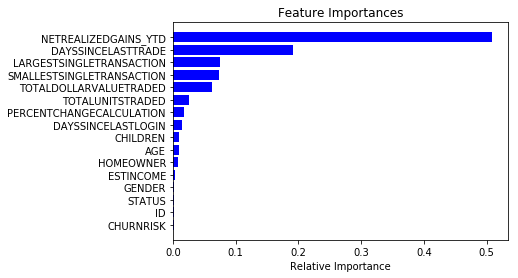

In [24]:
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b',align='center')
plt.yticks(range(len(indices)), (np.array(features))[indices])
plt.xlabel('Relative Importance')

Before we save the random forest classifier to repository, let us first evaluate the performance of a simple Naive Bayes classifier trained on the training dataset. 

In [25]:
nb=NaiveBayes(labelCol="label", featuresCol="features")

stages_nb = stages

stages_nb[-2] = nb

pipeline_nb = Pipeline(stages = stages_nb)

# Build models
model_nb = pipeline_nb.fit(train)
results_nb = model_nb.transform(test)

print('Naive Bayes Model Precision = {:.2f}.'.format(results_nb.filter(results_nb.label == results_nb.prediction).count() / float(results_nb.count())))

Naive Bayes Model Precision = 0.51.


As you can see from the results above, Naive Bayes classifier does not perform well. Random forest classifier shows high F-measure upon evaluation and shows strong performance. Hence, we will save this model to the repository.

<a id="save_model"></a>
## 5. Save the model into ML repository 
[Top](#top)

In [26]:
save(name='TradingChurnRiskClassificationSparkML',
     model=model,
     test_data = test,
     algorithm_type='Classification',
     description='This is a SparkML Model to Classify Trading Customer Churn Risk')

Using TensorFlow backend.


{'path': '/user-home/1042/DSX_Projects/TradingCustomerChurn/models/TradingChurnRiskClassificationSparkML/1',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python35/spark-2.2/TradingCustomerChurn/TradingChurnRiskClassificationSparkML/1'}

In [27]:
# Write the test data without label to a .csv so that we can later use it for batch scoring
write_score_CSV=test.toPandas().drop(['CHURNRISK'], axis=1)
write_score_CSV.to_csv('../datasets/TradingCustomerSparkMLBatchScore.csv', sep=',', index=False)

In [28]:
# Write the test data to a .csv so that we can later use it for Evaluation
write_eval_CSV=test.toPandas()
write_eval_CSV.to_csv('../datasets/TradingCustomerSparkMLEval.csv', sep=',', index=False)

<a id="summary"></a>
## 6. Summary
[Top](#top)

You have finished working on this hands-on lab. In this notebook you created a model using SparkML API, deployed it in Machine Learning service for online (real time) scoring and tested it using a test client.

Created by **Anjali Shah** and **Rui Fan** 

anjali.shah@ibm.com<br/>
rui.fan@ibm.com<br/>

August 2018